# 1. Importing Libraries

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer, PowerTransformer, Normalizer, RobustScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA

from matplotlib import pyplot

from imblearn.over_sampling import SMOTE

# PlottingNet 
sns.set()
%matplotlib inline

# 2. Importing Data

In [2]:
df_raw = pd.read_csv('data.csv')

# 3. Exploratory Data Analysis and Data Preparation

## 3.1 Preview of the raw data

In [3]:
df_raw

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


## 3.2 Missing values

In [4]:
df_raw.isna().values.any()

False

This shows that there are **no missing values** in the dataset.

## 3.3 Dividing the feature set from label set

In [7]:
df_X_raw = df_raw.iloc[:, 1:]
df_y_raw = df_raw.iloc[:, 0]

print(f'Shape of the feature set:', df_X_raw.shape)
print(f'Shape of the label set:', df_y_raw.shape)

Shape of the feature set: (6819, 95)
Shape of the label set: (6819,)


## 3.4 Divide the raw dataset into bankrupt and non-bankrupt companies (1 = banktupt, 0 = non-bankrupt)

In [8]:
df_non_bankrupt = df_raw[df_raw['Bankrupt?'] == 0]
df_bankrupt = df_raw[df_raw['Bankrupt?'] == 1]

print(f'Shape of the non-bankrupt set:', df_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_bankrupt.shape)

Shape of the non-bankrupt set: (6599, 96)
Shape of the bankrupt set: (220, 96)


## 3.5 Plot the label data (check for imbalance)

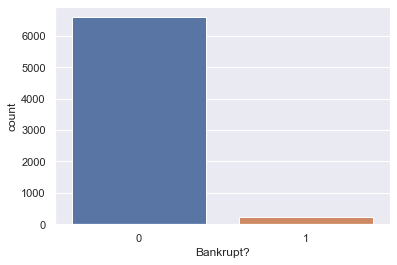

In [9]:
sns.countplot(x='Bankrupt?', data=df_raw)
plt.show()

This plot shows the imbalance of the data; there is ratio 30:1 for non-bankrupt and bankrupt companies.

## 3.6 Variance

### 3.6.1 Extracting standard deviations of the features

In [10]:
stds = df_X_raw.std(axis = 0)
stds = stds.sort_values(ascending=False)

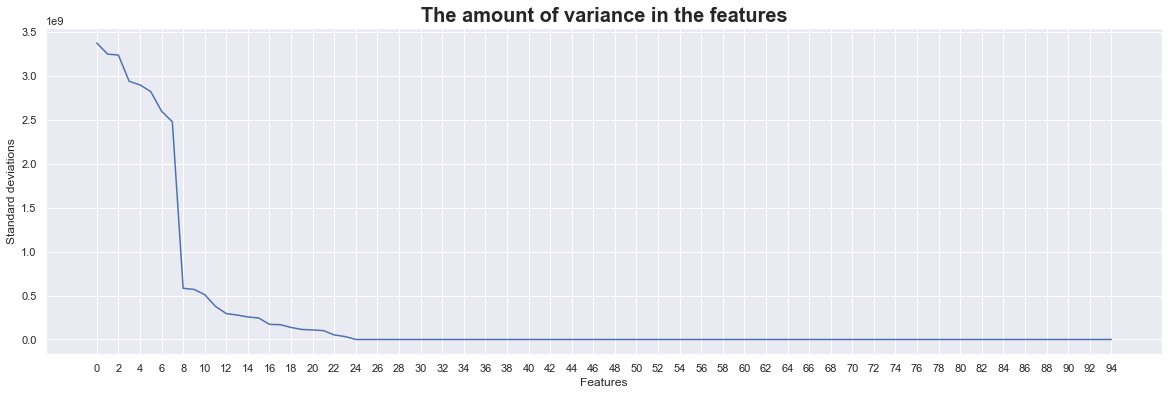

In [11]:
plt.figure(figsize=(20,6))
plt.plot([*range(95)], stds.values)
plt.title('The amount of variance in the features', fontsize=20, fontweight='bold')
plt.xlabel('Features')
plt.ylabel('Standard deviations')
plt.xticks(range(0, 95, 2))
plt.show()

The tail becomes unreadable because of the magnitude of y-axis. Therefore, we plot the tail (24:) in the next figure.

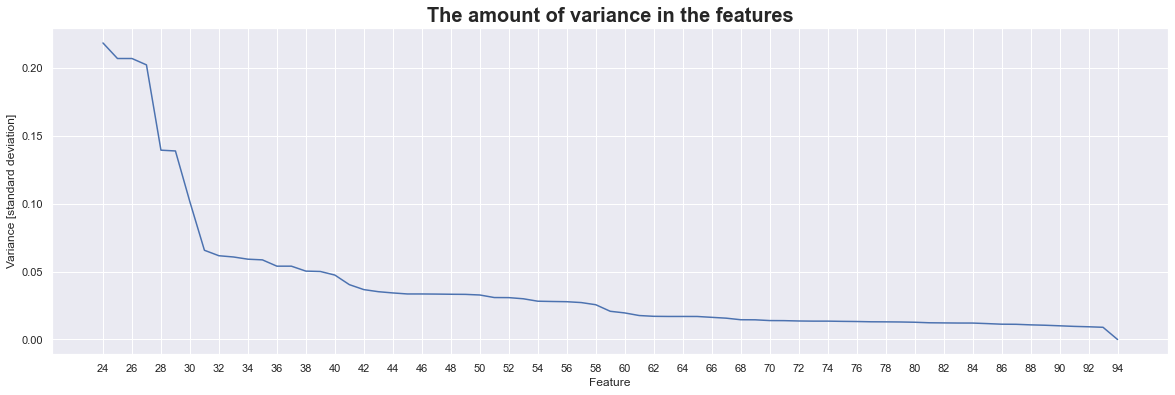

In [12]:
plt.figure(figsize=(20,6))
plt.plot([*range(24,95)], stds.values[24:])
plt.title('The amount of variance in the features', fontsize=20, fontweight='bold')
plt.xlabel('Feature')
plt.ylabel('Variance [standard deviation]')
plt.xticks(range(24, 95, 2))
plt.show()

In [13]:
stds

 Quick Asset Turnover Rate               3.374944e+09
 Inventory Turnover Rate (times)         3.247967e+09
 Operating Expense Rate                  3.237684e+09
 Cash Turnover Rate                      2.938623e+09
 Total Asset Growth Rate                 2.897718e+09
                                             ...     
 Continuous Net Profit Growth Rate       1.006296e-02
 Total Asset Return Growth Rate Ratio    9.634209e-03
 Cash Flow to Sales                      9.341346e-03
 Working capitcal Turnover Rate          8.959384e-03
 Net Income Flag                         0.000000e+00
Length: 95, dtype: float64

There is one feature that has no variance (Net Income Flag). This means that it takes the same value for every datapoint.

### 3.6.2 Getting rid of the features with no variance

In [14]:
# Creating a copy of the raw dataset
df_X_EDA_var = df_X_raw.copy()

# Removing the useless feature
df_X_EDA_var.drop(' Net Income Flag', axis=1, inplace=True)

print(f'Shape of the new dataset:', df_X_EDA_var.shape)

Shape of the new dataset: (6819, 94)


## 3.7 Scaling

In [16]:
# Transforming data to have a mean of 0 and std of 1 (99% of values are [-3, 3])
scaler = StandardScaler()
df_X_EDA_scaled = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_scaled.loc[:,:] = scaler.fit_transform(df_X_EDA_var)

In [76]:
# Scaling all values to [0, 1]
min_max_scaler = MinMaxScaler()
df_X_EDA_minmax = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_minmax.loc[:,:] = min_max_scaler.fit_transform(df_X_EDA_var)

In [77]:
# Scaling all values to [-1, 1]
max_abs_scaler = MaxAbsScaler()
df_X_EDA_maxabs = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_maxabs.loc[:,:] = max_abs_scaler.fit_transform(df_X_EDA_var)

In [83]:
# Scaling statistically using the Inter-Quartile Range (using the bulk of the data, so robust to outliers)
robust_scaler = RobustScaler()
df_X_EDA_robust = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_robust.loc[:,:] = robust_scaler.fit_transform(df_X_EDA_var)

In [84]:
# Appling non-linear transformation to map features to a uniform distribution
uniform_scaler = QuantileTransformer(output_distribution='uniform')
df_X_EDA_uniform = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_uniform.loc[:,:] = uniform_scaler.fit_transform(df_X_EDA_var)

In [86]:
# Appling non-linear transformation to map features to a Gaussian distribution
gaussian_scaler = QuantileTransformer(output_distribution='normal')
df_X_EDA_gaussian = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_gaussian.loc[:,:] = gaussian_scaler.fit_transform(df_X_EDA_var)

In [87]:
# Appling power-like transformation to make the data more Gaussian-like
power_scaler = PowerTransformer(method='yeo-johnson')
df_X_EDA_power = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_power.loc[:,:] = power_scaler.fit_transform(df_X_EDA_var)

C:\Users\mstep\anaconda3\lib\site-packages\numpy\core\_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\mstep\anaconda3\lib\site-packages\numpy\core\_methods.py:216: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims)


In [89]:
# Normalizing the samples individually to unit norm. Row-based normalization technique
normalizer = Normalizer()
df_X_EDA_norm = df_X_EDA_var.copy()    # to save the names of the features
df_X_EDA_norm.loc[:,:] = normalizer.fit_transform(df_X_EDA_var)

## 3.8 Correlation

### 3.8.1 Pairwise correlation between features and labels

In [19]:
# Correlation between the features and the labels
feat_label_corr = df_X_EDA_scaled.corrwith(df_y_raw)

# Sort descending
feat_label_corr_sorted = feat_label_corr.abs().sort_values(ascending=False)

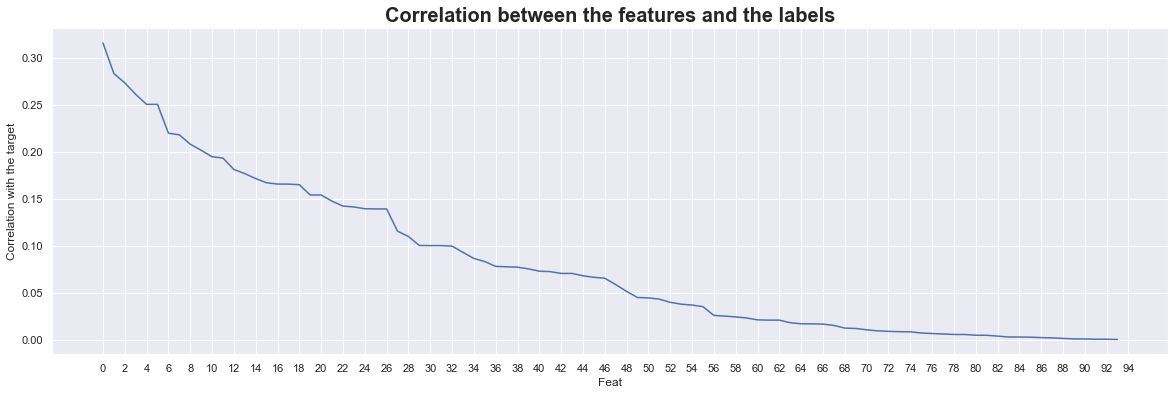

In [20]:
# Plotting
plt.figure(figsize=(20,6))
plt.plot([*range(94)],feat_label_corr_sorted.values)
plt.title('Correlation between the features and the labels', fontsize=20, fontweight='bold')
plt.xlabel('Feat')
plt.ylabel('Correlation with the target')
plt.xticks(range(0, 95, 2))
plt.show()

The correlation of the features with the ranges from 32% to almost 0%. We decide to set a threshold of **correlation to 1% in order to deem a feature predictive**. Therefore, we drop the features that are correlated with the label in less than 1% (23 features).

In [21]:
# Sorting the features set with descending correlation with the labels
new_col = feat_label_corr_sorted.index
new_col = new_col.to_numpy()
df_X_EDA_scaled_sorted = df_X_EDA_scaled.reindex(columns=new_col)

### 3.8.2 Dropping features with correlation < 0.1 with the labels

In [22]:
# Features to drop
feat_to_drop = feat_label_corr_sorted[feat_label_corr_sorted < 0.01].index

# Dropping
df_X_EDA_scaled_sorted_dropped = df_X_EDA_scaled_sorted.drop(feat_to_drop, axis=1)

print(f'Shape of the new dataset:', df_X_EDA_scaled_sorted_dropped.shape)

Shape of the new dataset: (6819, 71)


### 3.8.3 Pairwise correlation between features

In [24]:
# Plotting
feat_corr_matrix = df_X_EDA_scaled_sorted_dropped.corr()
feat_corr_matrix.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

### 3.8.4 Extracting the highly correlated features

In [25]:
def correlation(df, threshold):
    ''' A function extracting highly correlated
    features (according to a threshold). '''
    
    correlated_features = []
    correlation_matrix = df.corr()
    
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i,j]) > threshold:
                feature = correlation_matrix.columns[i]
                if feature not in correlated_features:
                    correlated_features.append(feature)

    return correlated_features

In [26]:
# A list of highly correlated features (more than 0.9)
corr_features = correlation(df_X_EDA_scaled_sorted_dropped, 0.9)

print('The list of highly correlated features:')

corr_features

The list of highly correlated features:


[' ROA(A) before interest and % after tax',
 ' ROA(B) before interest and depreciation after tax',
 ' ROA(C) before interest and depreciation before interest',
 ' Debt ratio %',
 ' Net profit before tax/Paid-in capital',
 ' Per Share Net profit before tax (Yuan ¥)',
 ' Liability to Equity',
 ' Net Value Per Share (B)',
 ' Net Value Per Share (C)',
 ' Current Liabilities/Equity',
 ' Current Liability to Equity',
 ' Operating profit/Paid-in capital',
 ' Operating Gross Margin',
 ' Realized Sales Gross Margin',
 ' Regular Net Profit Growth Rate',
 ' Current Liabilities/Liability']

### 3.8.5 Dropping the highly correlated features

We want to drop the highly correlated features and **keep the ones (out of each pair) that have higher correlation with labels**.

In [27]:
# Dropping
df_X_EDA_scaled_sorted_dropped_2 = df_X_EDA_scaled_sorted_dropped.drop(corr_features, axis=1)

print(f'Shape of the new dataset:', df_X_EDA_scaled_sorted_dropped_2.shape)

Shape of the new dataset: (6819, 55)


In [28]:
# Plotting the correlation matrix
feat_corr_matrix_dropped = df_X_EDA_scaled_sorted_dropped_2.corr()
feat_corr_matrix_dropped.style.background_gradient(cmap='coolwarm', axis=None).set_precision(3)

## 3.9 Balancing the Dataset

We decided to tackle the imbalance of the dataset problem by applying SMOTE and stratified sampling.

In [44]:
# Concatinate feature and label sets
df_scaled_imbalanced = pd.concat([df_y_raw, df_X_EDA_scaled], axis=1)
df_manually_clean = pd.concat([df_y_raw, df_X_manually_clean], axis=1)

# Divide for bankrupt and non-bankrupt sets
df_scaled_non_bankrupt = df_scaled_imbalanced[df_scaled_imbalanced['Bankrupt?'] == 0]
df_scaled_bankrupt = df_scaled_imbalanced[df_scaled_imbalanced['Bankrupt?'] == 1]

df_manually_clean_non_bankrupt = df_manually_clean[df_manually_clean['Bankrupt?'] == 0]
df_manually_clean_bankrupt = df_manually_clean[df_manually_clean['Bankrupt?'] == 1]

print(f'Only standardized data:\nShape of the non-bankrupt set:', df_scaled_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_scaled_bankrupt.shape)

print(f'\nManually cleaned data:\nShape of the non-bankrupt set:', df_manually_clean_non_bankrupt.shape)
print(f'Shape of the bankrupt set:', df_manually_clean_bankrupt.shape)

Only standardized data:
Shape of the non-bankrupt set: (6599, 95)
Shape of the bankrupt set: (220, 95)

Manually cleaned data:
Shape of the non-bankrupt set: (6599, 56)
Shape of the bankrupt set: (220, 56)


### 3.9.1 Stratified Sampling

We go about stratified sampling technique by simply **multiplying the datapoints of underrepresented class 1** until the number of datapoints matches the number of datapoints in the majority class 0.

In [46]:
def stratify(df):
    ''' Function upsampling a dataset by
    repeating the same values. It creates 
    a set of 6599 datapoints out of 220. '''

    df_strat = df.copy()
    for i in range(28):
        df_strat = pd.concat([df_strat, df], ignore_index=True)

    # Add 219 first datasets to match the non-bankrupt count
    df_strat = pd.concat([df_strat, df[:-1]], ignore_index=True)

    return df_strat

In [48]:
# Stratify the sets
df_scaled_bankrupt_strat = stratify(df_scaled_bankrupt)
df_manually_clean_bankrupt_strat = stratify(df_manually_clean_bankrupt)

# Combining the classes
df_stratified_scaled = pd.concat([df_scaled_non_bankrupt, df_scaled_bankrupt_strat], ignore_index=True)
df_stratified_manually_cleaned = pd.concat([df_manually_clean_non_bankrupt, df_manually_clean_bankrupt_strat], ignore_index=True)

print(f'The stratified standardized set:', df_stratified_scaled.shape)
print(f'The stratified manually cleaned set:', df_stratified_manually_cleaned.shape)

The stratified standardized set: (13198, 95)
The stratified manually cleaned set: (13198, 56)


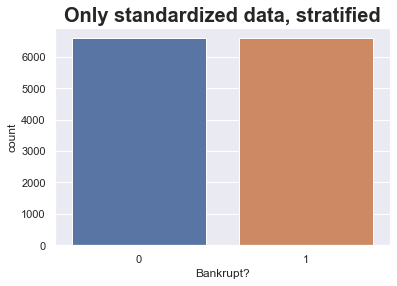

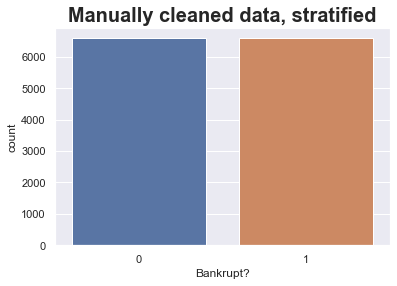

In [52]:
# Plotting the classes
sns.countplot(x='Bankrupt?', data=df_stratified_scaled)
plt.title('Only standardized data, stratified', fontsize=20, fontweight='bold')
plt.show()

sns.countplot(x='Bankrupt?', data=df_stratified_manually_cleaned)
plt.title('Manually cleaned data, stratified', fontsize=20, fontweight='bold')
plt.show()

Classes are perfectly balanced.

### 3.9.2 SMOTE

In [53]:
smote = SMOTE()
df_X_scaled_smote, df_y_smote = smote.fit_resample(df_X_EDA_scaled, df_y_raw)
df_X_manually_clean_smote, df_y_smote = smote.fit_resample(df_X_manually_clean, df_y_raw)

df_SMOTE_scaled = pd.concat([df_y_smote, df_X_scaled_smote], axis=1)
df_SMOTE_manually_cleaned = pd.concat([df_y_smote, df_X_manually_clean_smote], axis=1)

print(f'SMOTE-ed standardized set:', df_SMOTE_scaled.shape)
print(f'SMOTE-ed manually cleaned set:', df_SMOTE_manually_cleaned.shape)

SMOTE-ed standardized set: (13198, 95)
SMOTE-ed manually cleaned set: (13198, 56)


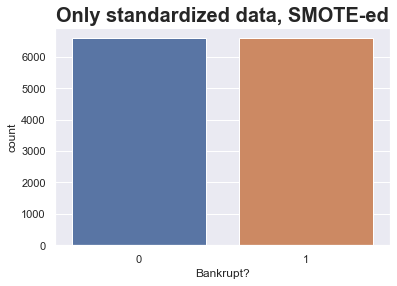

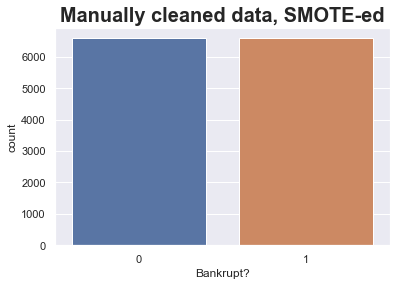

In [54]:
# Plotting the classes
sns.countplot(x='Bankrupt?', data=df_SMOTE_scaled)
plt.title('Only standardized data, SMOTE-ed', fontsize=20, fontweight='bold')
plt.show()

sns.countplot(x='Bankrupt?', data=df_SMOTE_manually_cleaned)
plt.title('Manually cleaned data, SMOTE-ed', fontsize=20, fontweight='bold')
plt.show()

Classes are perfectly balanced.

## 3.10 PCA

In [92]:
# Applying PCA to data
pca = PCA()
pca.fit(df_X_manually_clean_smote)
df_pca = pca.transform(df_X_manually_clean_smote)   # INPUT DESIRED FEATURE SET HERE!

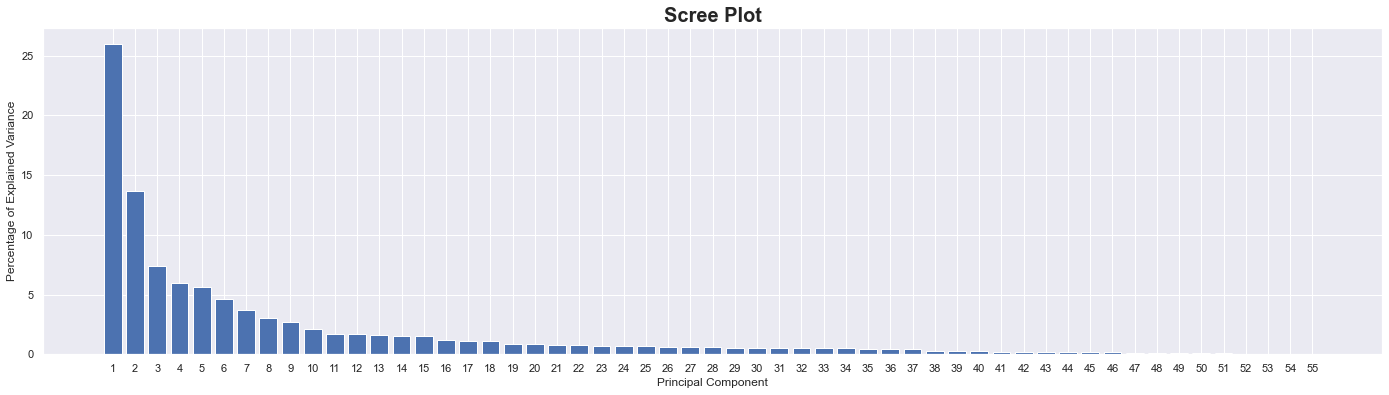

In [96]:
# Scree plot
per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.figure(figsize=(24,6))
plt.bar(x=range(1, len(per_var)+1), height=per_var, tick_label=labels)
plt.title('Scree Plot', fontsize=20, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Explained Variance')
plt.show()

## 3.11 Train - val - test split

In [71]:
# Splitting train:val:test 60:20:20
X_train, X_test, y_train, y_test = train_test_split(df_X_scaled_smote, df_y_smote, test_size=0.2, random_state=0)   # INPUT THE DESIRED FEATURE SET HERE!
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0) # 0.25 x 0.8 = 0.2

## 3.10 Permutation Feature Importance

In [68]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

results = permutation_importance(rfc, X_val, y_val)
importance = results.importances_mean

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.00121
Feature: 1, Score: -0.00038
Feature: 2, Score: 0.00295
Feature: 3, Score: 0.00242
Feature: 4, Score: 0.00061
Feature: 5, Score: 0.00045
Feature: 6, Score: 0.00106
Feature: 7, Score: 0.01841
Feature: 8, Score: 0.00106
Feature: 9, Score: 0.00008
Feature: 10, Score: 0.00008
Feature: 11, Score: -0.00030
Feature: 12, Score: -0.00038
Feature: 13, Score: -0.00068
Feature: 14, Score: 0.00159
Feature: 15, Score: -0.00106
Feature: 16, Score: 0.00114
Feature: 17, Score: 0.00053
Feature: 18, Score: 0.00045
Feature: 19, Score: 0.00250
Feature: 20, Score: 0.00030
Feature: 21, Score: -0.00182
Feature: 22, Score: 0.00000
Feature: 23, Score: 0.00076
Feature: 24, Score: 0.00008
Feature: 25, Score: -0.00038
Feature: 26, Score: -0.00098
Feature: 27, Score: 0.00053
Feature: 28, Score: -0.00053
Feature: 29, Score: 0.00068
Feature: 30, Score: -0.00068
Feature: 31, Score: 0.00000
Feature: 32, Score: 0.00000
Feature: 33, Score: -0.00045
Feature: 34, Score: 0.00015
Feature: 35, Score:

In [67]:
rfc.score(X_val, y_val)

0.9768939393939394

In [70]:
df_X_manually_clean_smote.iloc[:,7]

0        0.959784
1        0.129305
2        0.272560
3        0.312459
4        0.022791
           ...   
13193    0.521812
13194    0.193551
13195    0.630120
13196    0.234454
13197    0.489551
Name:  Borrowing dependency, Length: 13198, dtype: float64

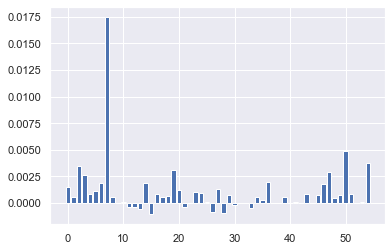

In [66]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

In [72]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)

results = permutation_importance(rfc, X_val, y_val)
importance = results.importances_mean

for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: -0.00091
Feature: 1, Score: 0.00083
Feature: 2, Score: -0.00220
Feature: 3, Score: 0.00061
Feature: 4, Score: 0.00053
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00008
Feature: 7, Score: -0.00091
Feature: 8, Score: -0.00053
Feature: 9, Score: -0.00167
Feature: 10, Score: 0.00038
Feature: 11, Score: -0.00015
Feature: 12, Score: -0.00015
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00038
Feature: 15, Score: -0.00098
Feature: 16, Score: -0.00053
Feature: 17, Score: -0.00015
Feature: 18, Score: -0.00136
Feature: 19, Score: 0.00008
Feature: 20, Score: 0.00000
Feature: 21, Score: -0.00008
Feature: 22, Score: 0.00076
Feature: 23, Score: 0.00008
Feature: 24, Score: -0.00030
Feature: 25, Score: 0.00038
Feature: 26, Score: 0.00008
Feature: 27, Score: -0.00023
Feature: 28, Score: 0.00129
Feature: 29, Score: 0.00000
Feature: 30, Score: 0.00045
Feature: 31, Score: 0.00015
Feature: 32, Score: 0.00000
Feature: 33, Score: 0.00000
Feature: 34, Score: 0.00144
Feature: 35, Sco

In [74]:
rfc.score(X_val, y_val)

0.9746212121212121

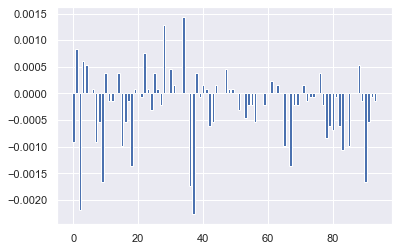

In [73]:
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## 3.9 Recursive Feature Elimination

## 3.9.1 Applying RFE using Random Forest

In [25]:
rfc = RandomForestClassifier(random_state=0)
rfecv = RFECV(rfc, cv=StratifiedKFold(10), scoring='accuracy')
rfecv.fit(df_X_EDA_scaled_sorted, df_y_raw)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=0), scoring='accuracy')

In [26]:
print(f'The optimal number of features:', rfecv.n_features_)

The optimal number of features: 54


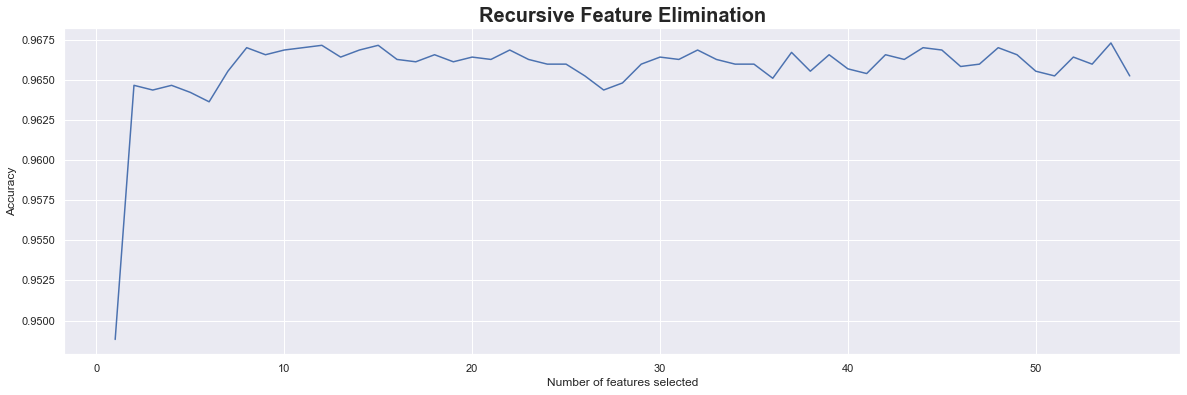

In [31]:
# Plotting
plt.figure(figsize=(20,6))
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.title('Recursive Feature Elimination', fontsize=20, fontweight='bold')
plt.xlabel('Number of features selected')
plt.ylabel('Accuracy')
plt.show()

In [36]:
rfecv.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

# Different Datasets after Data Preparation

In [56]:
# Only features with variance = 0 removed: df_X_EDA_var
print(f'Only features with variance = 0 removed:', df_X_EDA_var.shape)

# Features with variance = 0 removed and standardized (z-score): df_X_EDA_scaled
print(f'Features with variance = 0 removed and standardized (z-score):', df_X_EDA_scaled.shape)

# Features with variance = 0 removed, standardized and sorted with descending correlation with the labels: df_X_EDA_scaled_sorted
print(f'Features with variance = 0 removed, standardized and sorted with descending correlation with the labels:', df_X_EDA_scaled_sorted.shape)

# Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed: df_X_EDA_scaled_sorted_dropped
print(f'Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed:', df_X_EDA_scaled_sorted_dropped.shape)

# Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed: df_X_EDA_scaled_sorted_dropped_2
print(f'Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed:', df_X_EDA_scaled_sorted_dropped_2.shape)

# Manually cleaned data (all of the above included): df_X_manually_clean
df_X_manually_clean = df_X_EDA_scaled_sorted_dropped_2.copy()
print(f'Manually cleaned data (all of the above included):', df_X_manually_clean.shape)

Only features with variance = 0 removed: (6819, 94)
Features with variance = 0 removed and standardized (z-score): (6819, 94)
Features with variance = 0 removed, standardized and sorted with descending correlation with the labels: (6819, 94)
Features with variance = 0 removed, standardized, sorted and with features of correlation < 0.1 with the labels removed: (6819, 71)
Features with variance = 0 removed, standardized, sorted, weakly correlated with labels and correlated > 0.9 with each other removed: (6819, 55)
Manually cleaned data (all of the above included): (6819, 55)


In [55]:
# Imbalanced dataset with features with variance = 0 removed and standardized: df_var_imbalanced
print(f'Imbalanced dataset with features with variance = 0 removed and standardized:', df_scaled_imbalanced.shape)

# Imbalanced dataset with manually cleaned data: df_manually_clean
print(f'Imbalanced dataset with manually cleaned data:', df_manually_clean.shape)

# The stratified standardized set: df_stratified_scaled
print(f'The stratified standardized set:', df_stratified_scaled.shape)

# The stratified manually cleaned set: df_stratified_manually_cleaned
print(f'The stratified manually cleaned set:', df_stratified_manually_cleaned.shape)

# SMOTE-ed standardized set: df_SMOTE_scaled
print(f'SMOTE-ed standardized set:', df_SMOTE_scaled.shape)

# SMOTE-ed manually cleaned set: df_SMOTE_manually_cleaned
print(f'SMOTE-ed manually cleaned set:', df_SMOTE_manually_cleaned.shape)

Imbalanced dataset with features with variance = 0 removed and standardized: (6819, 95)
Imbalanced dataset with manually cleaned data: (6819, 56)
The stratified standardized set: (13198, 95)
The stratified manually cleaned set: (13198, 56)
SMOTE-ed standardized set: (13198, 95)
SMOTE-ed manually cleaned set: (13198, 56)
